# Previsão de indicadores de performance usando técnicas de econometria e IA. 
Criado por Lucas Moreira Gomes em 8 de Janeiro de 2025. [Documento Disponível no GitHub](https://github.com/lucasmoreira/embrapii). 

### Objetivo
Este projeto tem como principal objetivo analisar séries temporais relacionadas à quantidade e ao valor de projetos contratados e concluídos ao longo de diversos meses e anos, bem como gerar previsões futuras (de 12 meses, por exemplo). Para isso, utilizamos dois métodos de previsão: (1) Regressão Linear (OLS) e (2) Redes Neurais Simples (MLPRegressor). Além disso, empregamos métricas como o MAPE (Mean Absolute Percentage Error) para avaliar a qualidade dos modelos, e apresentamos previsões tanto para um conjunto de teste quanto para períodos futuros, de forma a auxiliar na tomada de decisão e no planejamento de projetos.

Inicialmente importamos as bibliotecas necessárias e visualizamos as primeiras linhas dos dados. 

In [1]:
#Importando Bibliotecas necessárias. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder

excel_file = 'embrapii_processo seletivo_analista dados senior_questao04.xlsx'
df = pd.read_excel(excel_file)

df.head()

,ano,mes,novos_projetos_contratados,valor_projetos_contratados,projetos_concluidos
0,2015,1,2,1614000.00,0
1,2015,2,1,2795707.10,0
2,2015,3,5,10534277.61,0
3,2015,4,6,29356275.99,0
4,2015,5,4,12533802.70,0


### Prepando os dados
Este trecho realiza a limpeza e padronização dos dados, convertendo valores no formato brasileiro para float, criando uma coluna de datas unificadas, definindo categorias de ano e mês, estabelecendo um índice temporal e, por fim, dividindo o conjunto em treino e teste.

In [2]:
# Criar coluna 'data' a partir de 'ano' e 'mes'
df['data'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str) + '-1')
df.sort_values('data', inplace=True)

# Categorias manuais para 'year' e 'month'
df['year']  = df['data'].dt.year.astype('category')
df['month'] = df['data'].dt.month.astype('category')

all_years  = list(range(2015, 2028))
all_months = list(range(1, 13))

df['year']  = df['year'].cat.set_categories(all_years)
df['month'] = df['month'].cat.set_categories(all_months)

# Criar 'time_idx' e remover colunas 'ano','mes' 
df['time_idx'] = np.arange(1, len(df) + 1)
df.drop(columns=['ano', 'mes'], inplace=True)

targets = [
    'novos_projetos_contratados',
    'valor_projetos_contratados',
    'projetos_concluidos'
]

# Criar colunas de lag (exemplo: lag1) para cada target
for var in targets:
    df[f'lag1_{var}'] = df[var].shift(1)

# Remover linhas com NaN nas lags
df.dropna(subset=[f'lag1_{v}' for v in targets], inplace=True)

#  Split Treino/Teste
train_size = int(len(df)*0.7)
df_train = df.iloc[:train_size].copy()
df_test  = df.iloc[train_size:].copy()

### Regressão Linear (OLS)
Este bloco de código treina um modelo de **Regressão Linear (OLS)** para cada variável-alvo, computa as previsões para o conjunto de teste e, em seguida, exibe tanto a métrica de erro (MAPE) quanto o resumo estatístico de cada modelo.

In [3]:
results = {}
for var in targets:
    formula = f"{var} ~ C(year) + C(month) + time_idx + lag1_{var}"
    model = smf.ols(formula=formula, data=df_train).fit()
    
    y_pred = model.predict(df_test)
    y_true = df_test[var]
    mape_test = mean_absolute_percentage_error(y_true, y_pred)*100
    
    results[var] = {
        'model': model,
        'MAPE_teste': mape_test
    }

for var in targets:
    print(f"\n=== OLS (com lag) para '{var}' ===")
    print(f"MAPE (teste): {results[var]['MAPE_teste']:.2f}%")
    print(results[var]['model'].summary())


=== OLS (com lag) para 'novos_projetos_contratados' ===
MAPE (teste): 18.99%
                                OLS Regression Results                                
Dep. Variable:     novos_projetos_contratados   R-squared:                       0.672
Model:                                    OLS   Adj. R-squared:                  0.577
Method:                         Least Squares   F-statistic:                     7.054
Date:                        Thu, 09 Jan 2025   Prob (F-statistic):           2.87e-09
Time:                                02:51:54   Log-Likelihood:                -253.36
No. Observations:                          81   AIC:                             544.7
Df Residuals:                              62   BIC:                             590.2
Df Model:                                  18                                         
Covariance Type:                    nonrobust                                         
                                      coef    std er

### Rede Neural (MLPRegressor)
Este trecho realiza o treino de uma Rede Neural (MLPRegressor) para cada variável-alvo. Para isso, primeiro aplicamos One-Hot Encoding nas colunas de ano e mês, depois concatenamos com o índice temporal para formar o conjunto de entrada (X) e, por fim, treinamos e avaliamos o modelo utilizando o MAPE no conjunto de teste.

In [4]:
encoder = OneHotEncoder(
    categories=[all_years, all_months],
    drop=None,
    sparse_output=False  
)
encoder.fit(df_train[['year', 'month']])

results_nn = {}
for var in targets:
    # Montar X de treino (year/month one-hot, time_idx, lag1_var)
    X_train_cat = encoder.transform(df_train[['year','month']])
    X_train_num = df_train[['time_idx']].values
    X_train_lag = df_train[[f'lag1_{var}']].values
    
    X_train = np.hstack([X_train_cat, X_train_num, X_train_lag])
    y_train = df_train[var].values
    
    mlp = MLPRegressor(
        hidden_layer_sizes=(64,128, 64),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42
    )
    mlp.fit(X_train, y_train)
    
    # Montar X de teste
    X_test_cat = encoder.transform(df_test[['year','month']])
    X_test_num = df_test[['time_idx']].values
    X_test_lag = df_test[[f'lag1_{var}']].values
    
    X_test = np.hstack([X_test_cat, X_test_num, X_test_lag])
    y_pred_nn = mlp.predict(X_test)
    y_true_nn = df_test[var].values
    
    mape_test_nn = mean_absolute_percentage_error(y_true_nn, y_pred_nn)*100
    
    results_nn[var] = {
        'model': mlp,
        'MAPE_teste': mape_test_nn
    }

for var in targets:
    print(f"\n=== NN (com lag) para '{var}' ===")
    print(f"MAPE (teste): {results_nn[var]['MAPE_teste']:.2f}%")



=== NN (com lag) para 'novos_projetos_contratados' ===
MAPE (teste): 22.36%

=== NN (com lag) para 'valor_projetos_contratados' ===
MAPE (teste): 35.03%

=== NN (com lag) para 'projetos_concluidos' ===
MAPE (teste): 26.80%


### Previsão próximos 12 meses
Este bloco de código gera um DataFrame futuro (com 12 meses à frente do último ponto do dataset), aplica os mesmos processos de codificação para ano e mês, e então estima as previsões tanto pelos modelos de Regressão Linear (OLS) quanto pelos modelos de Rede Neural (MLP), armazenando todos os resultados em dicionários separados para posterior visualização.

In [5]:
last_date = df['data'].max()
future_periods = 12
current_time_idx = df['time_idx'].max()

futures = []
for i in range(1, future_periods+1):
    next_date = last_date + pd.offsets.MonthBegin(i)
    futures.append({
        'data': next_date,
        'year': next_date.year,
        'month': next_date.month,
        'time_idx': current_time_idx + i
    })

df_future = pd.DataFrame(futures)
df_future['year']  = df_future['year'].astype('category').cat.set_categories(all_years)
df_future['month'] = df_future['month'].astype('category').cat.set_categories(all_months)

# Preencher a lag1 de modo simplificado: último valor real
for var in targets:
    last_known_value = df[var].iloc[-1]
    df_future[f'lag1_{var}'] = last_known_value

# Marcar a fase (histórico vs. futuro)
df['phase'] = 'historical'
df_future['phase'] = 'future'

df_full = pd.concat([df, df_future], ignore_index=True)
df_full.sort_values('time_idx', inplace=True)
df_full.reset_index(drop=True, inplace=True)

# 5B.1) OLS
for var in targets:
    model_ols = results[var]['model']
    # df_full contém as colunas: year, month, time_idx, lag1_{var}, etc.
    df_full[f'ols_pred_{var}'] = model_ols.predict(df_full)

# 5B.2) NN
X_full_cat = encoder.transform(df_full[['year','month']])
X_full_num = df_full[['time_idx']].values

future_preds_nn = {}
for var in targets:
    model_nn = results_nn[var]['model']
    
    X_full_lag = df_full[[f'lag1_{var}']].values
    X_full = np.hstack([X_full_cat, X_full_num, X_full_lag])
    
    df_full[f'nn_pred_{var}'] = model_nn.predict(X_full)


### Gráficos comparativos
Neste trecho, geramos gráficos comparativos que mostram a série histórica de cada variável-alvo e as previsões futuras obtidas pelos modelos de Regressão Linear (OLS) e Rede Neural (MLP), possibilitando uma visualização clara das tendências passadas e projetadas.

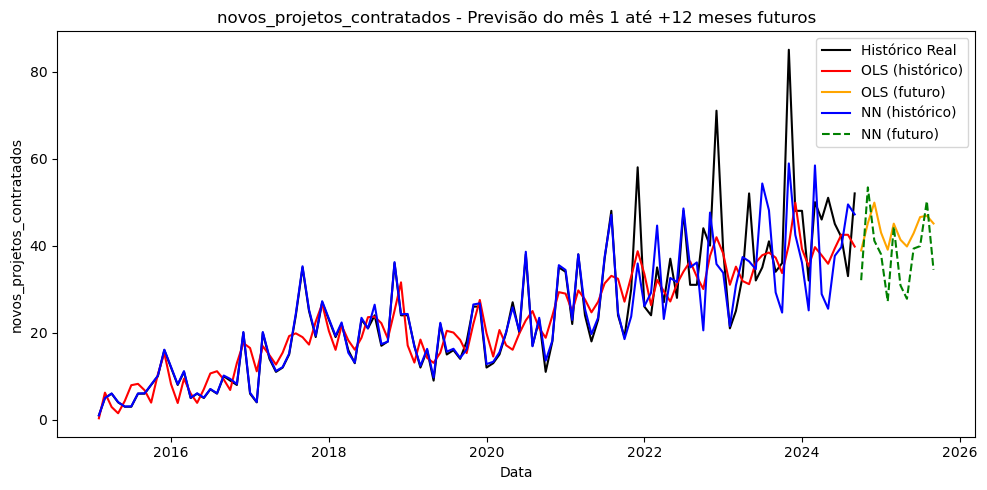

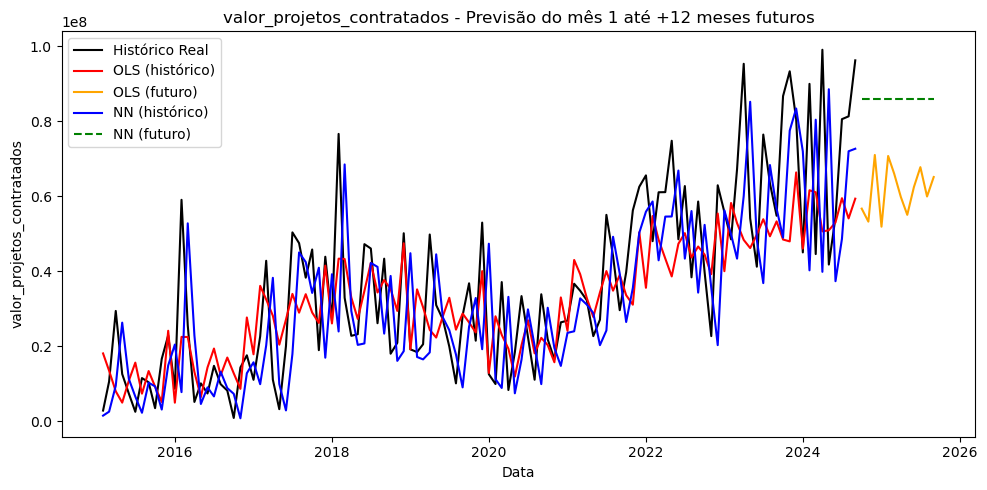

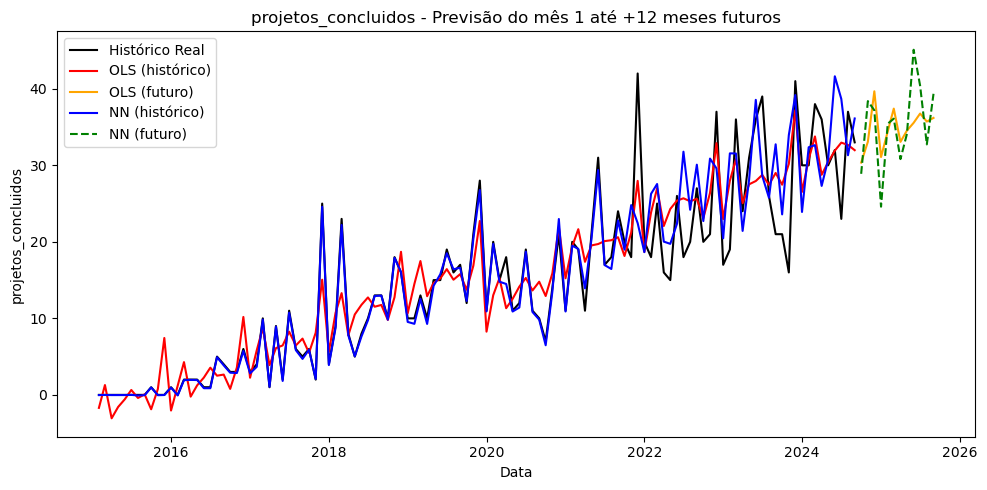

In [6]:
for var in targets:
    plt.figure(figsize=(10, 5))
    
    # Separar DataFrame em histórico e futuro
    df_hist = df_full[df_full['phase'] == 'historical']
    df_fut  = df_full[df_full['phase'] == 'future']
    
    # (a) Plot do histórico REAL (apenas 'historical')
    plt.plot(df_hist['data'], df_hist[var],
             label='Histórico Real', color='black')
    
    # (b) Plot da predição OLS no histórico (vermelho) e no futuro (laranja)
    plt.plot(df_hist['data'], df_hist[f'ols_pred_{var}'],
             label='OLS (histórico)', color='red')
    plt.plot(df_fut['data'], df_fut[f'ols_pred_{var}'],
             label='OLS (futuro)', color='orange')
    
    # (c) Plot da predição NN no histórico (azul) e no futuro (verde tracejado)
    plt.plot(df_hist['data'], df_hist[f'nn_pred_{var}'],
             label='NN (histórico)', color='blue')
    plt.plot(df_fut['data'], df_fut[f'nn_pred_{var}'],
             label='NN (futuro)', color='green', linestyle='--')
    
    plt.title(f"{var} - Previsão do mês 1 até +12 meses futuros")
    plt.xlabel("Data")
    plt.ylabel(var)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Previsões de 2025 (OLS & NN) para cada variável-alvo

In [10]:
df_2025 = df_full.loc[
    (df_full['phase'] == 'future') & 
    (df_full['data'].dt.year == 2025)
].copy()

selected_cols = ['data']
for var in targets:
    selected_cols.append(f'ols_pred_{var}')
    selected_cols.append(f'nn_pred_{var}')

df_2025 = df_2025[selected_cols]

rename_dict = {}
for var in targets:
    rename_dict[f'ols_pred_{var}'] = f'OLS_{var}'
    rename_dict[f'nn_pred_{var}']  = f'NN_{var}'

df_2025.rename(columns=rename_dict, inplace=True)

df_2025

,data,OLS_novos_projetos_contratados,NN_novos_projetos_contratados,OLS_valor_projetos_contratados,NN_valor_projetos_contratados,OLS_projetos_concluidos,NN_projetos_concluidos
119,2025-01-01,42.995111,38.029847,5.182282e+07,8.595026e+07,31.081390,24.593149
120,2025-02-01,39.065280,27.197023,7.068281e+07,8.595027e+07,34.423435,35.437286
121,2025-03-01,45.057788,44.385418,6.596990e+07,8.595027e+07,37.410431,36.097057
122,2025-04-01,41.348652,30.876730,5.976011e+07,8.595027e+07,33.064284,30.811963
123,2025-05-01,39.810948,27.795416,5.498369e+07,8.595027e+07,34.542004,34.117741
124,2025-06-01,42.856851,39.326813,6.241450e+07,8.595027e+07,35.553288,45.100743
125,2025-07-01,46.566451,39.896746,6.769733e+07,8.595027e+07,36.767287,40.400598
126,2025-08-01,46.874178,50.245574,5.987418e+07,8.595027e+07,35.719285,32.734984
127,2025-09-01,45.087293,34.482808,6.506959e+07,8.595027e+07,36.195858,39.345736


### Conclusão

Os resultados mostram que, para “novos_projetos_contratados” e “projetos_concluidos”, o modelo de regressão linear (OLS) obteve MAPE ligeiramente menor do que a rede neural (NN), sugerindo que a abordagem linear capturou de forma mais eficiente o padrão nesses casos. Já para “valor_projetos_contratados”, a OLS também apresentou erro relativamente menor (26,78%) em comparação à NN (35,03%), mas ambos os modelos apresentaram resultados mais altos neste indicador, possivelmente pela maior variação ou complexidade desse valor.

A rede neural tem a vantagem de captar não linearidades e relações mais complexas, mas pode precisar de mais dados, tuning de hiperparâmetros e camadas para atingir resultados superiores. A OLS, por outro lado, é mais simples, rápida e fornece coeficientes de fácil interpretação, mas pode não capturar bem relações altamente não lineares.

Concluindo, neste teste específico, a OLS (com lag) apresentou resultados melhores (MAPE menor) na maioria das variáveis, sugerindo que a estrutura linear, com inclusão de lags, foi suficiente para explicar o padrão dos dados. Contudo, vale considerar ajustes de rede neural ou ampliação do dataset para melhor explorar potenciais não linearidades no futuro.